In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import libpysal as lps
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import KernelDensity

import matplotlib.dates as mdates

In [3]:
# read zipfile
df = pd.read_csv('data/data_selection_17_23.csv')

In [4]:
df['dt']=pd.to_datetime(df['timestamp'], unit='s')    
df['datetime'] = df['dt'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [5]:
# drop nan values
df_clean = df.dropna()
df_clean

,timestamp,nodeid,temperature,humidity,voltage,light,dt,datetime
65178,1505010,1,21.8112,34.64030,2.48502,478.40,1970-01-18 10:03:30,1970-01-18 10:03:30
65179,1505010,2,22.3306,35.23020,2.46440,537.28,1970-01-18 10:03:30,1970-01-18 10:03:30
65180,1505010,3,21.8896,35.02220,2.49546,412.16,1970-01-18 10:03:30,1970-01-18 10:03:30
65187,1505010,10,22.3600,34.32730,2.49546,625.60,1970-01-18 10:03:30,1970-01-18 10:03:30
65190,1505010,13,19.9296,39.00820,2.44412,1494.08,1970-01-18 10:03:30,1970-01-18 10:03:30
...,...,...,...,...,...,...,...,...
931613,1986360,6,122.1530,-3.91901,2.22442,0.92,1970-01-23 23:46:00,1970-01-23 23:46:00
931761,1986420,46,76.9362,45.37430,2.21612,1.38,1970-01-23 23:47:00,1970-01-23 23:47:00
931849,1986480,26,19.8904,53.12660,2.32910,0.46,1970-01-23 23:48:00,1970-01-23 23:48:00
931935,1986540,4,122.1530,38.63340,2.29313,5.06,1970-01-23 23:49:00,1970-01-23 23:49:00


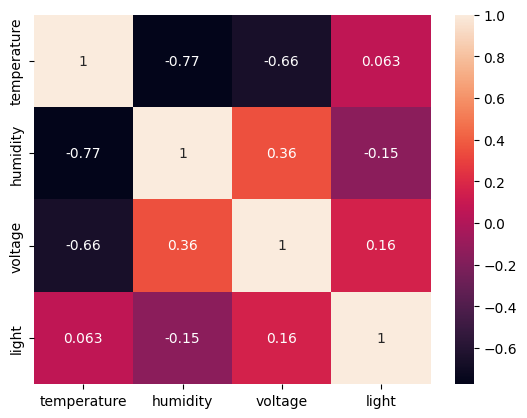

In [6]:
sns.heatmap(df_clean[['temperature','humidity','voltage','light']].corr(method='pearson'), annot=True)
plt.show()

In [7]:
# calculate the correlation between temperature and humidity for each node
correlation = df_clean.groupby('nodeid')[['humidity','voltage']].corr().iloc[0::2,-1].reset_index()


<Axes: xlabel='nodeid', ylabel='voltage'>

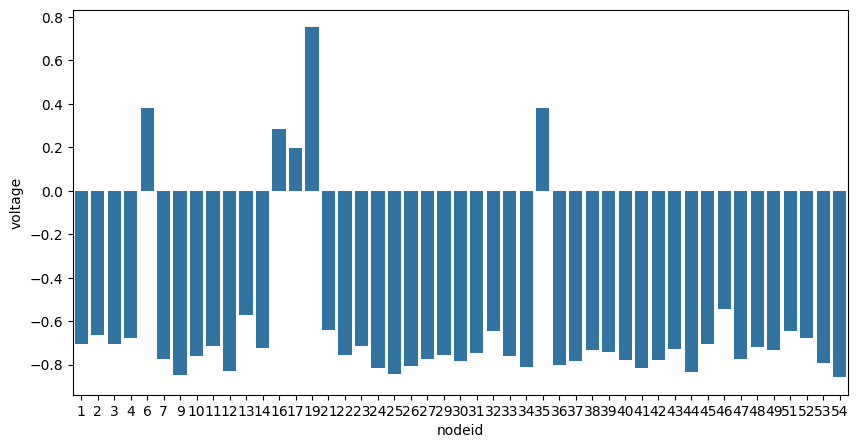

In [8]:
# plot the correlation 
plt.figure(figsize=(10,5))
sns.barplot(x='nodeid', y='voltage', data=correlation)
# the x-axis is nodeid, tilt the x-axis
# plt.xticks(rotation=45)

In [9]:
# rank humidity from high to low
correlation = correlation.sort_values(by='voltage', ascending=False)
correlation[['nodeid','voltage']]

,nodeid,voltage
14,19,0.752870
4,6,0.383190
28,35,0.380495
12,16,0.283452
13,17,0.197322
39,46,-0.541576
10,13,-0.569684
15,21,-0.639054
25,32,-0.645124
43,51,-0.647084


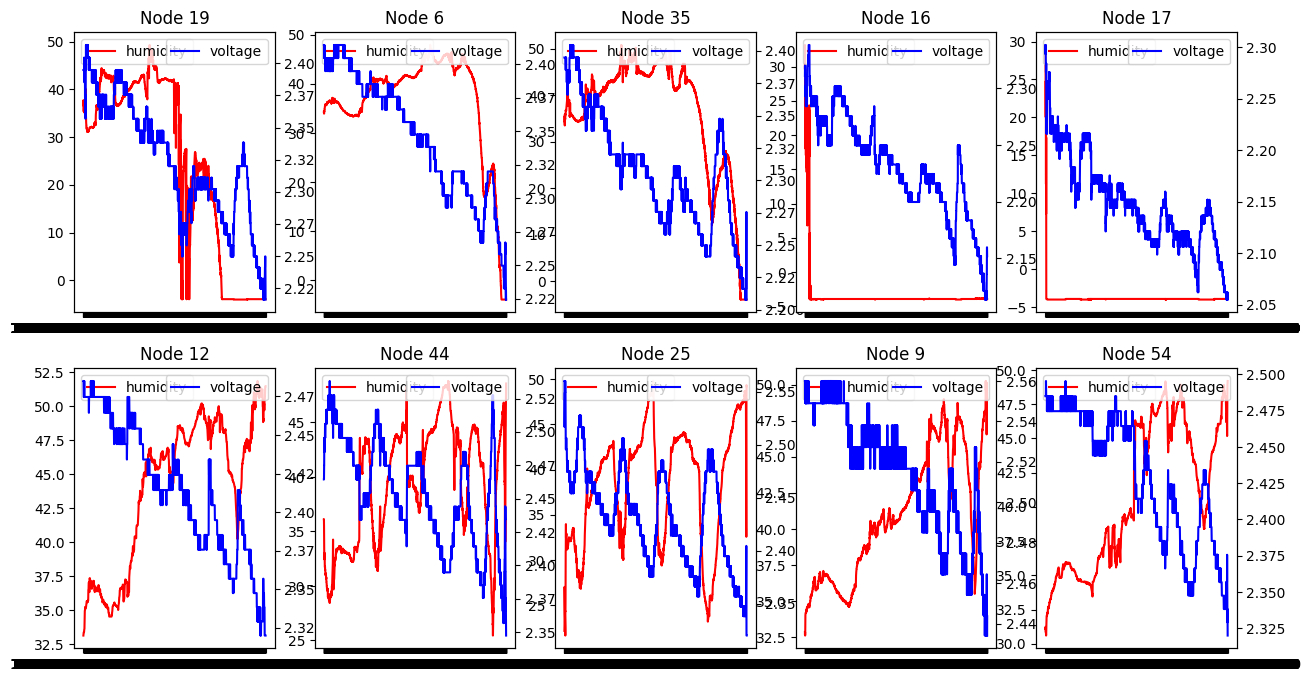

In [ ]:
# alert!!!!!!! 4 mins
# plot the temperature and humidity for each node
plt.figure(figsize=(15,8))
idx=0
list_to_plot = correlation['nodeid'].values[:5].tolist()+correlation['nodeid'].values[-5:].tolist()
for i in correlation['nodeid'].values[:5].tolist()+correlation['nodeid'].values[-5:].tolist():
    idx=idx+1

    plt.subplot(2, 5, idx)
    data=df_clean[df_clean['nodeid']==i]
    plt.plot(data['datetime'],data['humidity'],label='humidity',color='r')
    plt.legend(loc='upper left')
    # plot the voltage on 2nd y-axis
    plt.twinx()
    plt.plot(data['datetime'],data['voltage'],label='voltage',color='b')
    plt.title('Node '+str(i))
    plt.legend(loc='upper right')
    plt.xticks(rotation=45)

In [8]:
# select the first timestamp
def spatial_correlation(df_clean, timestamp,distance, window=50, channel='temperature', visualize=True,bandwidth=0.1, critical_value=1):
    # get all data from timestamp-window to timestamp+window
    window_ts=df_clean[(df_clean['timestamp'] > timestamp-window) & (df_clean['timestamp'] < timestamp+window)] # not used??? howdd
    one_ts=df_clean[df_clean['timestamp'] == timestamp]
    if one_ts.shape[0]<2:
        return
    # print('data at this timestamp',one_ts.shape)
    # select the ids of the sensors based on one_ts.nodeid
    ids=one_ts['nodeid'].values-1
    one_ts_similarity=distance[ids][:,ids]
    sparse_similarity=lps.weights.util.full2W(one_ts_similarity) # this must be the distance matrix, not similarity matrix
    sparse_similarity.transform='r'
    y= one_ts[channel]
    ylag=lps.weights.lag_spatial(sparse_similarity,y)
    
    if visualize:
        plt.plot(y,ylag,'o')
        try:
            b, a = np.polyfit(y, ylag, 1)
            plt.plot(y, a + b*y, label=channel)
        except Exception as e:
            print(e)
    return find_anamaly(y,ylag, ids+1, bandwidth=bandwidth, critical_value=critical_value)

def find_anamaly(y,ylag, ids, bandwidth=1, critical_value=0.1):
    reshaped_data=ylag.reshape(-1,1)
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(reshaped_data)
    log_density = kde.score_samples(reshaped_data)

    anomaly_ids=ids[np.exp(log_density)<(critical_value)] # dataframe is 1-indexed
    # if anomaly_ids.size>0:
    #     plt.scatter(ylag,np.exp(log_density))
    # if anomaly_ids.size>0:
    #     print(y,ylag,anomaly_ids)
    return  anomaly_ids

In [9]:
# get location of the sensors
position_data = pd.read_csv('./data/labapp3-positions.txt', sep=' ', names=['nodeid','x','y'])
position_data.set_index('nodeid', inplace=True)
# create a distance matrix

position=np.array(position_data)
distance=squareform(pdist(position))

# similarity matrix
similarity=np.exp(-distance**2/(100))
# how the sparse similarity matrix looks like
sparse_similarity=lps.weights.util.full2W(similarity[:5,:5])
#sparse_similarity.weights

In [144]:
df_timestamp_clean=df.drop(['humidity','voltage','light'],axis=1).dropna()

timestamps = df_timestamp_clean['timestamp'].unique()
anomaly_findings={}
for i in range(0,len(timestamps)):
# for i in range(13000,13010):
    anomaly_idx=spatial_correlation(df_timestamp_clean, timestamps[i], similarity, window=50, visualize=False,bandwidth=1, critical_value=0.05)
    # check anomaly_idx is not empty
    if anomaly_idx is not None and len(anomaly_idx)>0:
        anomaly_findings[timestamps[i]]=anomaly_idx
anomaly_findings

{1514280: array([17, 21]),
 1514340: array([17, 21, 22]),
 1514490: array([13, 17, 21]),
 1514520: array([17, 21]),
 1514550: array([46]),
 1515090: array([12, 17, 48]),
 1515210: array([16, 19]),
 1515270: array([17, 19, 21, 22]),
 1515300: array([17, 21]),
 1515360: array([12, 17, 19, 21]),
 1515390: array([17, 19, 21]),
 1515420: array([12, 14, 17, 21]),
 1515450: array([16, 17, 21, 22]),
 1515480: array([25]),
 1516440: array([41]),
 1518840: array([16]),
 1518870: array([38]),
 1519170: array([16]),
 1519260: array([16, 19, 21]),
 1519320: array([13, 16]),
 1521810: array([25]),
 1524570: array([14, 16]),
 1524660: array([17, 22]),
 1525350: array([16]),
 1525770: array([13, 17]),
 1525830: array([14, 17]),
 1526550: array([16]),
 1526760: array([11, 16]),
 1526790: array([13, 14, 16]),
 1526820: array([17]),
 1526850: array([17, 19, 21]),
 1526880: array([12, 13, 17, 21]),
 1526970: array([16]),
 1527000: array([11, 16, 19]),
 1527240: array([12, 17, 21]),
 1527420: array([13, 17

In [145]:
# plot the anomaly findings
# make anomaly findings as a df
anomaly_df = pd.DataFrame(columns=['timestamp','nodeid'])
for key, value in anomaly_findings.items():
    for i in value:
        anomaly_df.loc[len(anomaly_df)]=[key,i]
anomaly_df

,timestamp,nodeid
0,1514280,17
1,1514280,21
2,1514340,17
3,1514340,21
4,1514340,22
...,...,...
34186,1939170,40
34187,1939170,42
34188,1939170,43
34189,1965270,21


In [146]:
# df[df['timestamp']==1900770]

In [ ]:
# save the anomaly findings
anomaly_df.to_csv('./data/anomaly_findings_moranI_temperature.csv', index=False)

In [147]:
# change the timestamp to datetime
anomaly_df['dt'] = pd.to_datetime(anomaly_df['timestamp'], unit='s')
# format the datetime to mm-dd hh:mm
anomaly_df['datetime'] = anomaly_df['dt'].dt.strftime('%Y-%m-%d %H:%M:%S')

<Axes: xlabel='datetime', ylabel='nodeid'>

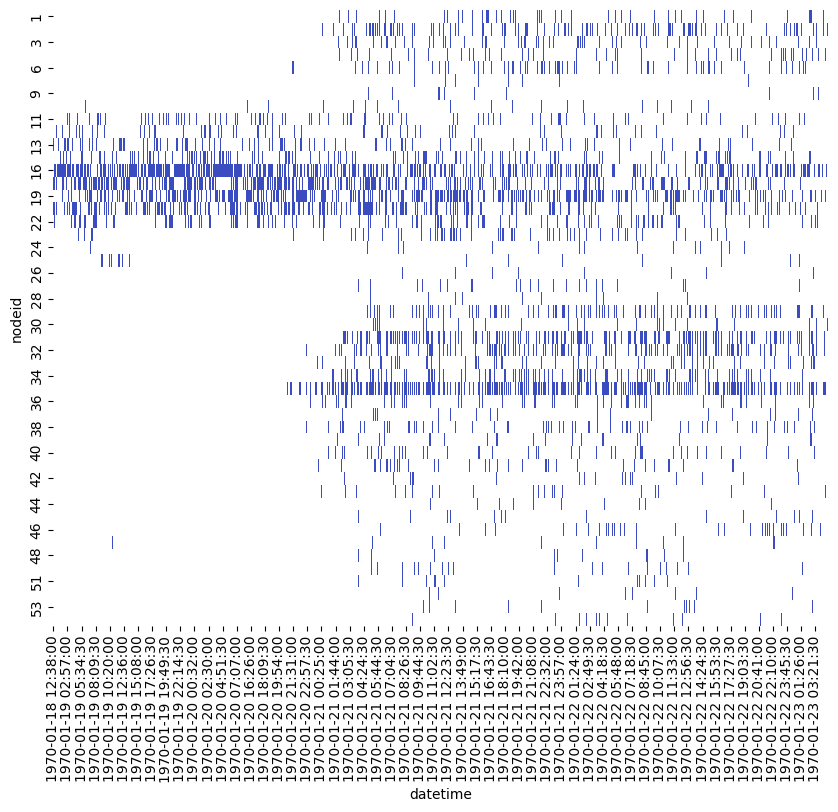

In [148]:
# plot the anomaly findings
plt.figure(figsize=(10,8))
sns.heatmap(anomaly_df.groupby(['nodeid','datetime']).size().unstack(),cmap='coolwarm',cbar=False)

In [149]:
def format_x_date_month_day(ax):   
    # Standard date x-axis formatting block, labels each month and ticks each day
    days = mdates.DayLocator()
    hours=mdates.HourLocator()
    months = mdates.MonthLocator()  # every month
    dayFmt = mdates.DateFormatter('%d  %H:%M')
    monthFmt = mdates.DateFormatter('%d-%H')
    ax.figure.autofmt_xdate()
    ax.xaxis.set_major_locator(days) 
    ax.xaxis.set_major_formatter(dayFmt)
    # ax.xaxis.set_minor_locator(hours)

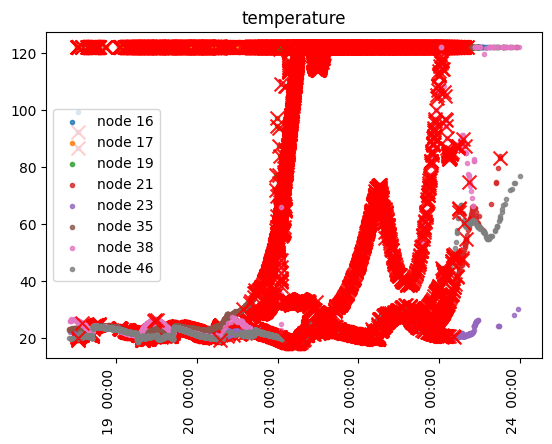

In [150]:
# select the first 1000 timestamps
unique_ts=df_timestamp_clean['timestamp'].unique()
first_timestamps = df_timestamp_clean[df_timestamp_clean['timestamp'].isin(unique_ts[:])]
fig, ax = plt.subplots()
# for node_id in [19,]:
for node_id in [16,17,19,21,23,35,38,46]:
    data = first_timestamps[first_timestamps['nodeid']==node_id]
    ad=anomaly_df[anomaly_df['nodeid']==node_id]
    # filter ad in this timestamp
    ad=ad[ad['timestamp'].isin(unique_ts[:])]
    ad['temperature']=data[data['timestamp'].isin(ad['timestamp'])]['temperature'].values   
    if data.shape[0]>-1:
        # data.plot(x='datetime',y='temperature',ax=ax,label='node '+str(node_id),alpha=0.8,marker='o')
        # ad.plot(x='datetime',y='temperature',ax=ax,label='anomaly',color='r',alpha=0.9,marker='x')
        ax.scatter(data['dt'],data['temperature'],label='node '+str(node_id),alpha=0.8,marker='.')
        ax.scatter(ad['dt'],data[data['timestamp'].isin(ad['timestamp'])]['temperature'].values,color='r',alpha=0.9,marker='x',s=100)
plt.title('temperature')
# ax.xaxis.set_major_formatter( mdates.DateFormatter('%m%d '))
# plt.plot(first_10_timestamps['datetime'],first_10_timestamps['temperature'])
plt.legend()
format_x_date_month_day(ax)
plt.xticks(rotation=90, ha= 'right')
plt.show()